[View in Colaboratory](https://colab.research.google.com/github/kumarshankar/FADML-Project/blob/master/FADML_wannacry1.ipynb)

In [2]:
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn import preprocessing

Using TensorFlow backend.


In [3]:
from google.colab import files
uploaded = files.upload()

Saving ransomware.txt to ransomware.txt
Saving regular.txt to regular.txt
Saving spec.txt to spec.txt


In [4]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "ransomware.txt" with length 68117 bytes
User uploaded file "regular.txt" with length 6506664 bytes
User uploaded file "spec.txt" with length 410860 bytes


In [0]:
ransom_data = pd.read_csv("ransomware.txt",sep=',',names=[ 'instructions','cache-references','cache-misses','branches','branch-misses'])
regular_data = pd.read_csv("regular.txt",sep=',',names=[ 'instructions','cache-references','cache-misses','branches','branch-misses'])
spec_data = pd.read_csv("spec.txt",sep=',',names=[ 'instructions','cache-references','cache-misses','branches','branch-misses'])

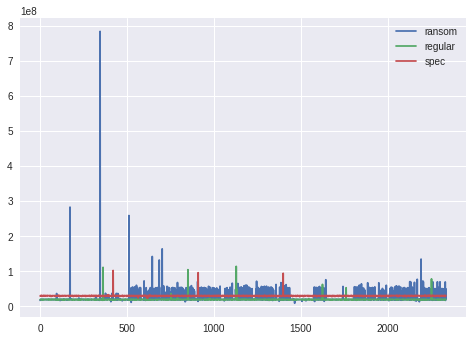

In [6]:
instrcomp = pd.DataFrame({'regular': regular_data.instructions,
                          'ransom': ransom_data.instructions,
                          'spec': spec_data.instructions})
instrcomp = instrcomp.iloc[:2335,:]

instrcomp.plot()

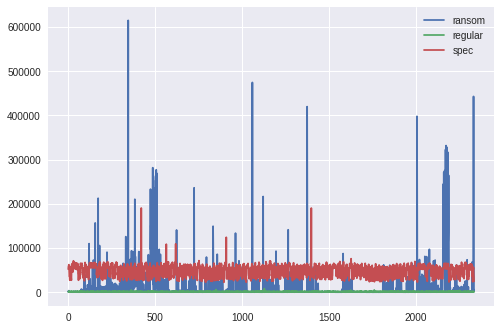

In [7]:
cacrefcomp = pd.DataFrame({'regular': regular_data[regular_data.columns[1]],
                          'ransom': ransom_data[ransom_data.columns[1]],
                          'spec': spec_data[spec_data.columns[1]] })

cacrefcomp = cacrefcomp.iloc[:2335,:]

cacrefcomp.plot()

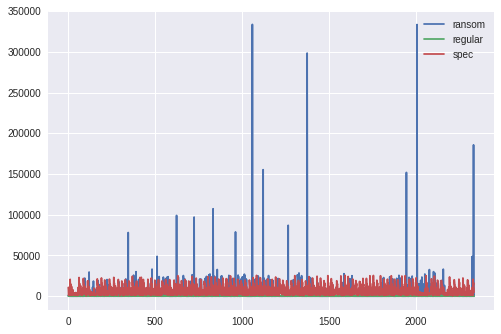

In [8]:
cacmisscomp = pd.DataFrame({'regular': regular_data[regular_data.columns[2]],
                          'ransom': ransom_data[ransom_data.columns[2]],
                          'spec': spec_data[spec_data.columns[2]]})

cacmisscomp = cacmisscomp.iloc[:2335,:]

cacmisscomp.plot()

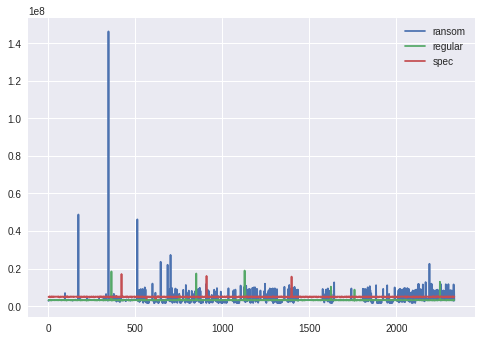

In [9]:
branchescomp = pd.DataFrame({'regular': regular_data.branches,
                          'ransom': ransom_data.branches,
                          'spec': spec_data.branches})

branchescomp = branchescomp.iloc[:2335,:]

branchescomp.plot()

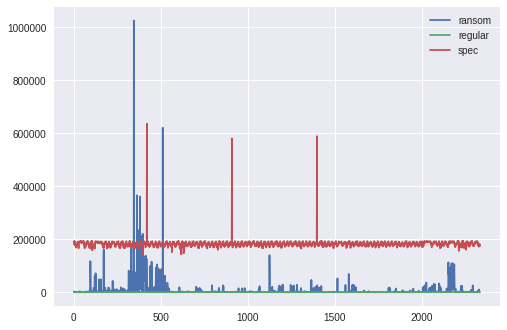

In [10]:
branchmisscomp = pd.DataFrame({'regular': regular_data[regular_data.columns[4]],
                          'ransom': ransom_data[ransom_data.columns[4]],
                          'spec': spec_data[spec_data.columns[4]]})

branchmisscomp = branchmisscomp.iloc[:2335,:]

branchmisscomp.plot()
plt.show()

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(regular_data)
regular_normalized = pd.DataFrame(np_scaled)
regular_normalized = regular_normalized.rename(columns= {0: 'instructions',
                                                         1:'cache-references',
                                                         2:'cache-misses',
                                                         3:'branches',
                                                         4:'branch-misses'})

In [0]:
import numpy as np

In [0]:
sequence_length = 51
result = []
for index in range(len(regular_normalized.instructions) - sequence_length):
    result.append(regular_normalized.instructions[index: index + sequence_length])
result = np.array(result)

In [0]:
reg_size_instructions = np.round(0.8 * result.shape[0])
train = result[:int(reg_size_instructions), :]
np.random.shuffle(train)
x_train = train[:, :-1]
y_train = train[:, -1]
x_test = result[int(reg_size_instructions):, :-1]
y_test = result[int(reg_size_instructions):, -1]

In [0]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

In [17]:
model = build_model([1, 50, 100, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(50, 1), return_sequences=True, units=50)`
  import sys


> Compilation Time :  0.02059483528137207


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
model.fit(
	    x_train,
	    y_train,
	    batch_size=512,
	    epochs=2,
	    validation_split=0.05)

Train on 170280 samples, validate on 8963 samples
Epoch 1/2
170280/170280 [==============================] - 78s 457us/step - loss: 4.7272e-05 - val_loss: 2.2860e-05
Epoch 2/2
110080/170280 [==================>...........] - ETA: 26s - loss: 3.7118e-05

170280/170280 [==============================] - 77s 451us/step - loss: 3.7382e-05 - val_loss: 1.8669e-05


In [0]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [0]:
predictions = predict_sequences_multiple(model, x_test, 50, 50)

In [0]:
pred_flat = (np.array(predictions)).flatten()

In [0]:
pred_flat1= np.append(pred_flat,[0.01]*11)

In [62]:
pred_flat1.shape == y_test.shape

True

In [70]:
(pred_flat1 > 0).all() 

True

In [0]:
from sklearn.metrics import log_loss

In [0]:
y_test = np.array(y_test,dtype=np.float64)

In [0]:
pred_flat1 = np.array(pred_flat1,dtype=np.float64)

In [0]:
error = np.sqrt(np.sum(np.square(pred_flat1 - y_test)))

In [80]:
error

1.2256010861523696

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
    plt.show()
    

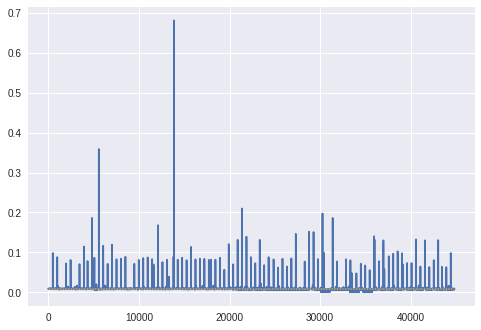

In [86]:
plot_results_multiple(predictions, y_test, 50)

In [0]:
# Now start testing on ransomware data

np_scaled = min_max_scaler.fit_transform(ransom_data)
ransom_normalized = pd.DataFrame(np_scaled)
ransom_normalized = ransom_normalized.rename(columns= {0: 'instructions',
                                                         1:'cache-references',
                                                         2:'cache-misses',
                                                         3:'branches',
                                                         4:'branch-misses'})

In [88]:
ransom_normalized.head()

,instructions,cache-references,cache-misses,branches,branch-misses
0,0.010398,0.002037,0.001343,0.008980,0.000507
1,0.010739,0.003678,0.000507,0.011302,0.000430
2,0.013540,0.000966,0.000108,0.011163,0.000316
3,0.013706,0.005655,0.002179,0.011217,0.002960
4,0.011934,0.002177,0.001256,0.010105,0.000564


In [0]:
sequence_length = 51
result = []
for index in range(len(ransom_normalized.instructions) - sequence_length):
    result.append(ransom_normalized.instructions[index: index + sequence_length])
result = np.array(result)

In [0]:
np.random.shuffle(result)
x_test = result[:, :-1]
y_test = result[:, -1]

In [91]:
x_test.shape

(2284, 50)

In [94]:
x_train.shape

(179243, 50, 1)

In [92]:
y_test.shape

(2284,)

In [0]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
pred_ransom = predict_sequences_multiple(model, x_test, 50, 50)

In [0]:
pred_ransom = np.array(pred_ransom)

In [98]:
pred_ransom.shape

(45, 50)

In [0]:
pred_ransom1 = pred_ransom.flatten()

In [103]:
pred_ransom1.shape

(2284,)

In [101]:
pred_ransom1[:5]

array([0.00768122, 0.00772168, 0.00774584, 0.00775771, 0.0077619 ],
      dtype=float32)

In [0]:
pred_ransom1 = np.append(pred_ransom1,[0.01]*34)

In [0]:
error = np.sqrt(np.sum(np.square(pred_ransom1 - y_test)))

In [105]:
error

1.5266368631935636

In [106]:
(1.5266-1.2256)/1.2256

0.24559399477806781

In [0]:
# 24.5 % of the ransom data is deviating from regular data